In [1]:
struct Delivery
    x::Float64
    y::Float64
end;
function random_delivery()
    x = rand(0.0:0.1:100.0)
    y = rand(0.0:0.1:100.0)
    return Delivery(x, y)
end;
random_delivery()

Delivery(74.8, 10.8)

In [2]:
struct TSProblem
    deliveries::Array{Delivery}
end;

function random_instance(n_deliveries)
    deliveries = [random_delivery() for _=1:n_deliveries]
    problem = TSProblem(deliveries)
    return problem
end;
random_instance(5)

TSProblem(Delivery[Delivery(85.0, 8.2), Delivery(44.9, 61.5), Delivery(30.2, 30.8), Delivery(13.0, 14.5), Delivery(60.8, 76.1)])

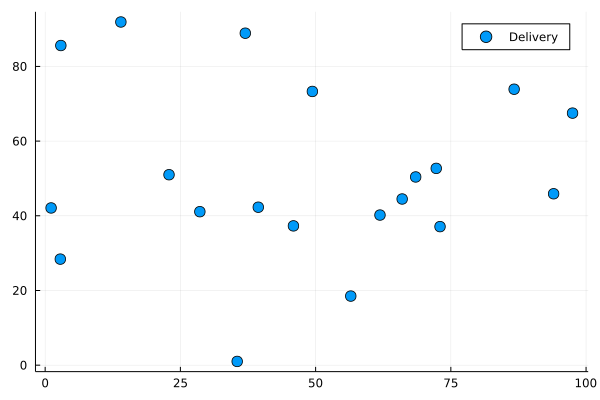

In [8]:
using Plots

function display_problem(problem)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    return scatter(x_pos, y_pos, shape = :circle, markersize = 6, label= "Delivery")
end;

problem = random_instance(20)
display_problem(problem)

In [4]:
function dist(del1::Delivery, del2::Delivery)
    return sqrt((del1.x - del2.x)^2 + (del1.y - del2.y)^2)
end
function calc_travelmatrix(deliveries::Array{Delivery})
    tm = zeros(Float64, length(deliveries), length(deliveries))
    for i = 1:length(deliveries)
        for j = 1:length(deliveries)
            tm[i, j] = dist(deliveries[i], deliveries[j])
        end
    end
    return tm
end
travelmatrix = calc_travelmatrix(problem.deliveries)

20×20 Matrix{Float64}:
  0.0     40.9106   36.034   26.9615   …  46.9703  30.5013   40.9034
 40.9106   0.0      35.509   45.539       79.6859  46.5597   66.6442
 36.034   35.509     0.0     58.5075      82.9411  61.3862   76.1552
 26.9615  45.539    58.5075   0.0         35.4295   3.62353  21.1085
 54.1671  72.6179   87.8388  29.4978      28.1945  27.103    15.7953
 38.1874   9.65194  41.5289  37.6128   …  72.5764  38.1965   58.6369
 62.3712  74.9569   94.2165  36.0068      39.5904  32.8877   26.9058
 40.1269  62.3953   30.1015  67.0767      78.769   70.6272   78.3084
 68.2539  54.104    85.9724  46.5626      74.0525  43.5409   57.1224
 45.3856  72.318    81.0     26.7905      13.1309  26.2728    5.69386
 32.8562  73.4507   58.0629  48.8771   …  42.1246  52.1509   48.572
 28.1469  63.1231   64.1007  23.2157      18.8404  25.4849   18.2439
 35.8134  69.4461   71.8017  26.8224      11.1611  28.2469   14.5248
 49.7893   9.12414  39.5092  54.1503      88.6273  54.9389   75.2471
 66.7216  7

In [5]:
using JuMP
import GLPK
import Test

model = Model(GLPK.Optimizer)
# route is an adjence matrix representing a route traveled
route=@variable(model, route[1:length(problem.deliveries), 1:length(problem.deliveries)], Bin)
# mtzu is a helper variable to ensure no subtours are allowed (only one continous tour)
# see MTZ constraint
mtzu = @variable(model, mtzu[1:length(problem.deliveries)], Int)

# ensure all events are planned
@constraint(model, [i = 1:length(problem.deliveries)], sum(route[i, :]) == 1.0)
# ensure there is just one route
@constraint(model, [c = 1:length(problem.deliveries)], sum(route[:, c]) == 1.0)
# disallow traveling to itself
@constraint(model, [j = 1:length(problem.deliveries)], route[j, j] == 0)

# MTZ constraints for removing subtours
n = length(problem.deliveries)
@constraint(model, [ui = 1:n, uj = 2:n], mtzu[ui] + route[ui, uj] <= mtzu[uj]+ (n - 1) * (1 - route[ui, uj]) )

traveltime = travelmatrix.* route 
@objective(model, Min, sum(traveltime))
optimize!(model)
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show objective_value(model)
@show value.(route)

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.NO_SOLUTION
objective_value(model) = 378.5578743633901
value.(route) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

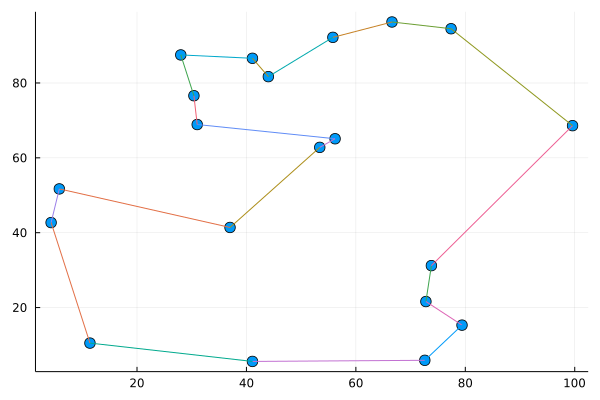

In [7]:
function display_solution(problem, route)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    plot_result = scatter(x_pos, y_pos, shape = :circle, markersize = 6)
    for i in 1:length(problem.deliveries)
        for j in 1:length(problem.deliveries)
            val = route[i, j]
            if val > 0
                del1 = problem.deliveries[i]
                del2 = problem.deliveries[j]
                plot!([del1.x, del2.x], [del1.y, del2.y], legend = false)
            end
        end
    end
    return plot_result
end;
display_solution(problem, value.(route))